In [1]:
import pickle
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm
from datasets import load_dataset

## Reading Cached GPT-3 Outputs

In [2]:
# ID_PATH = indices in WikiBio of the evaluated examples
id_path = "/home/pm574/rds/hpc-work/self-consistency/cache/top5_seed25_100.txt"
with open(id_path, 'r') as f:
    id_lines = f.readlines()
ids = [int(i.strip()) for i in id_lines]
print(ids)

[394, 1829, 2704, 3239, 4716, 7980, 8024, 9719, 10028, 10740, 12018, 12948, 13854, 14165, 15337, 15362, 15637, 16751, 18639, 18912, 20063, 20483, 21020, 21350, 21429, 21948, 22407, 22475, 22701, 22748, 22778, 22780, 23297, 23680, 24695, 25585, 25678, 28103, 28572, 29397, 29703, 31676, 32313, 33007, 33117, 34231, 34892, 35880, 35884, 36388, 37096, 37972, 37992, 39945, 40317, 40445, 40518, 40559, 41918, 43863, 43944, 45696, 46523, 50200, 50586, 51311, 51500, 53531, 55347, 55551, 55672, 56337, 57088, 57109, 57341, 57415, 57437, 57533, 57740, 59798, 61460, 62464, 63257, 65678, 65695, 65811, 66425, 66940, 67253, 67982, 68722, 69787, 70485, 70595, 70625, 70696, 70846, 71127, 71565, 72052]


In [3]:
# GPT-3's reponse
# response = openai.Completion.create(
#     model="text-davinci-003",
#     prompt=f"This is a passage from Wikipedia about {context}:\n\n",
#     temperature=temperature, # 0.0 = deterministic
#     max_tokens=max_length,
#     logprobs=logprobs,
# )
# type(response.choices[0].text)     => str
# type(response.choices[0].logprobs) => openai.openai_object.OpenAIObject

responses = {}
for idx in ids:
    path = f"/home/pm574/rds/hpc-work/self-consistency/llm_outputs/passage_top5_seed25_100/gpt3_davinci_003_FEB15_v1_logprob/{idx}.bin"
    with open(path, "rb") as f:
        response = pickle.load(f)
    responses[idx] = response

## load `wiki_bio_gpt3_hallucination` data

In [4]:
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
dataset = dataset['train']

Using custom data configuration potsawee--wiki_bio_gpt3_hallucination-e8e8a8d1fbf50281
Found cached dataset json (/home/pm574/rds/hpc-work/downloads/hf_datasets/potsawee___json/potsawee--wiki_bio_gpt3_hallucination-e8e8a8d1fbf50281/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
label_mapping = {
    'accurate': 0.0,
    'minor_inaccurate': 0.5,
    'major_inaccurate': 1.0,
}

In [6]:
# 1 = True, 0 = Minor-False, -1 = Major-False
human_label_detect_False   = {}
human_label_detect_False_h = {}
human_label_detect_True    = {}
for i_ in range(len(dataset)):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    raw_label = np.array([label_mapping[x] for x in dataset_i['annotation']])
    human_label_detect_False[idx] = (raw_label > 0.499).astype(np.int32).tolist()
    human_label_detect_True[idx]  = (raw_label < 0.499).astype(np.int32).tolist()
    average_score = np.mean(raw_label)
    if average_score <= 0.75:
        human_label_detect_False_h[idx] = (raw_label > 0.499).astype(np.int32).tolist()

In [7]:
len(human_label_detect_False), len(human_label_detect_True), len(human_label_detect_False_h)

(65, 65, 41)

# Experimental Setup

In [8]:
def unroll_pred(scores, indices):
    unrolled = []
    for idx in indices:
        unrolled.extend(scores[idx])
    return unrolled

In [9]:
def get_PR_with_human_labels(preds, human_labels, pos_label=1, oneminus_pred=False):
    indices = [k for k in human_labels.keys()]
    unroll_preds = unroll_pred(preds, indices)
    if oneminus_pred:
        unroll_preds = [1.0-x for x in unroll_preds]
    unroll_labels = unroll_pred(human_labels, indices)
    assert len(unroll_preds) == len(unroll_labels)
    print("len:", len(unroll_preds))
    P, R, thre = precision_recall_curve(unroll_labels, unroll_preds, pos_label=pos_label)
    return P, R

In [10]:
def print_AUC(P, R):
    print("AUC: {:.2f}".format(auc(R, P)*100))

In [11]:
baseline1_scores = {} # average_logprob
baseline2_scores = {} # lowest_logprob
baseline3_scores = {} # average_ppl5
baseline4_scores = {} # highest_ppl5

In [12]:
for i_ in tqdm(range(len(dataset))):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    sentences = dataset_i['gpt3_sentences']
    num_sentences = len(sentences)
    
    # from the cache
    passage = responses[idx].choices[0].text
    tokens = responses[idx].choices[0].logprobs.tokens
    token_logprobs = responses[idx].choices[0].logprobs.token_logprobs
    top_logprobs = responses[idx].choices[0].logprobs.top_logprobs
    
    average_logprob_sent_level = [None for _ in range(num_sentences)]
    lowest_logprob_sent_level = [None for _ in range(num_sentences)]
    average_ppl5_sent_level = [None for _ in range(num_sentences)]
    highest_ppl5_sent_level = [None for _ in range(num_sentences)]
        
    for sent_i, sentence in enumerate(sentences):
        # sentence exist in the passage, so we need to find where it is [i1, i2]
        xarr = [i for i in range(len(tokens))]
        for i1 in xarr:
            mystring = "".join(tokens[i1:])
            if sentence not in mystring:
                break
        i1 = i1 - 1
        for i2 in xarr[::-1]:
            mystring = "".join(tokens[i1:i2+1])
            if sentence not in mystring:
                break
        i2 = i2 + 1
        mystring = "".join(tokens[i1:i2+1])
        average_logprob = np.mean(token_logprobs[i1:i2+1])
        lowest_logprob  = np.min(token_logprobs[i1:i2+1])
        ppl5s = []
        for top5_tokens in top_logprobs[i1:i2+1]:
            logprob_of_top5_tokens = [x[1] for x in list(top5_tokens.items())]
            logprob_of_top5_tokens = np.array(logprob_of_top5_tokens)
            prob_of_top5_tokens = np.exp(logprob_of_top5_tokens)
            total_prob_of_top5 = prob_of_top5_tokens.sum()
            normalized_prob = prob_of_top5_tokens / total_prob_of_top5
            ppl5 = 2**(entropy(normalized_prob, base=2))
            ppl5s.append(ppl5)
        average_ppl5 = np.mean(ppl5s)
        highest_ppl5 = np.max(ppl5s)

        average_logprob_sent_level[sent_i] = average_logprob
        lowest_logprob_sent_level[sent_i] = lowest_logprob
        average_ppl5_sent_level[sent_i] = average_ppl5
        highest_ppl5_sent_level[sent_i] = highest_ppl5

    baseline1_scores[idx] = average_logprob_sent_level
    baseline2_scores[idx] = average_ppl5_sent_level
    baseline3_scores[idx] = lowest_logprob_sent_level
    baseline4_scores[idx] = highest_ppl5_sent_level

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 184.76it/s]


## Experimet1: Detecting False

In [13]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [14]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(baseline1_scores, human_label_detect_False, pos_label=1, oneminus_pred=True)
Pb2, Rb2 = get_PR_with_human_labels(baseline2_scores, human_label_detect_False, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(baseline3_scores, human_label_detect_False, pos_label=1, oneminus_pred=True)
Pb4, Rb4 = get_PR_with_human_labels(baseline4_scores, human_label_detect_False, pos_label=1)
print("-----------------------")
print("Baseline1: Avg(LogProb)")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("Baseline2: Avg(PPL)")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("Baseline3: Lowest(LogProb)")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("Baseline4: Highest(PPL)")
print_AUC(Pb4, Rb4)

len: 526
len: 526
len: 526
len: 526
-----------------------
Baseline1: Avg(LogProb)
AUC: 83.67
-----------------------
Baseline2: Avg(PPL)
AUC: 82.02
-----------------------
Baseline3: Lowest(LogProb)
AUC: 86.16
-----------------------
Baseline4: Highest(PPL)
AUC: 83.82


In [15]:
arr = []
for v in human_label_detect_False.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.7566539923954373

Text(0.5, 0, 'Recall')

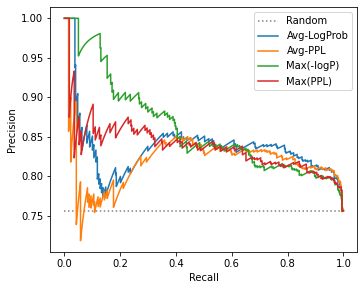

In [16]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='Avg-LogProb')
plt.plot(Rb2, Pb2, '-', label='Avg-PPL')
plt.plot(Rb3, Pb3, '-', label='Max(-logP)')
plt.plot(Rb4, Pb4, '-', label='Max(PPL)')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")

## Experiment2: Detect False* (harder/less-trivial)

In [17]:
# with human label, Detecting False
Pb1, Rb1 = get_PR_with_human_labels(baseline1_scores, human_label_detect_False_h, pos_label=1, oneminus_pred=True)
Pb2, Rb2 = get_PR_with_human_labels(baseline2_scores, human_label_detect_False_h, pos_label=1)
Pb3, Rb3 = get_PR_with_human_labels(baseline3_scores, human_label_detect_False_h, pos_label=1, oneminus_pred=True)
Pb4, Rb4 = get_PR_with_human_labels(baseline4_scores, human_label_detect_False_h, pos_label=1)
print("-----------------------")
print("Baseline1: Avg(LogProb)")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("Baseline2: Avg(PPL)")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("Baseline3: Lowest(LogProb)")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("Baseline4: Highest(PPL)")
print_AUC(Pb4, Rb4)

len: 322
len: 322
len: 322
len: 322
-----------------------
Baseline1: Avg(LogProb)
AUC: 70.63
-----------------------
Baseline2: Avg(PPL)
AUC: 67.70
-----------------------
Baseline3: Lowest(LogProb)
AUC: 76.51
-----------------------
Baseline4: Highest(PPL)
AUC: 72.15


In [18]:
arr = []
for v in human_label_detect_False_h.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.6024844720496895

Text(0.5, 0, 'Recall')

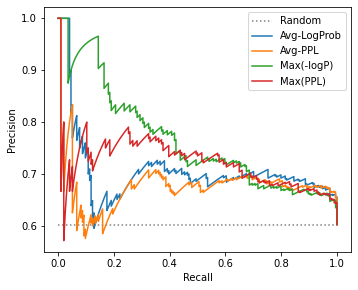

In [19]:
# with human label, Detecting Non-factual*
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='Avg-LogProb')
plt.plot(Rb2, Pb2, '-', label='Avg-PPL')
plt.plot(Rb3, Pb3, '-', label='Max(-logP)')
plt.plot(Rb4, Pb4, '-', label='Max(PPL)')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")

## Experiment3: Detecting True

In [20]:
# with human label, Detecting True
Pb1, Rb1 = get_PR_with_human_labels(baseline1_scores, human_label_detect_True, pos_label=1, oneminus_pred=False)
Pb2, Rb2 = get_PR_with_human_labels(baseline2_scores, human_label_detect_True, pos_label=1, oneminus_pred=True)
Pb3, Rb3 = get_PR_with_human_labels(baseline3_scores, human_label_detect_True, pos_label=1, oneminus_pred=False)
Pb4, Rb4 = get_PR_with_human_labels(baseline4_scores, human_label_detect_True, pos_label=1, oneminus_pred=True)
print("-----------------------")
print("Baseline1: Avg(LogProb)")
print_AUC(Pb1, Rb1)
print("-----------------------")
print("Baseline2: Avg(PPL)")
print_AUC(Pb2, Rb2)
print("-----------------------")
print("Baseline3: Lowest(LogProb)")
print_AUC(Pb3, Rb3)
print("-----------------------")
print("Baseline4: Highest(PPL)")
print_AUC(Pb4, Rb4)

len: 526
len: 526
len: 526
len: 526
-----------------------
Baseline1: Avg(LogProb)
AUC: 48.67
-----------------------
Baseline2: Avg(PPL)
AUC: 48.45
-----------------------
Baseline3: Lowest(LogProb)
AUC: 44.22
-----------------------
Baseline4: Highest(PPL)
AUC: 45.26


In [21]:
arr = []
for v in human_label_detect_True.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.24334600760456274

Text(0.5, 0, 'Recall')

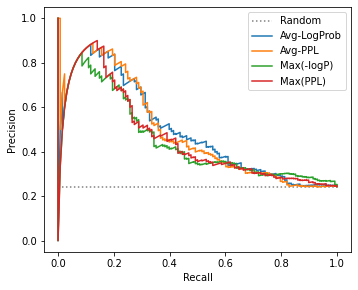

In [22]:
# with human label, Detecting Non-factual*
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random') 
plt.plot(Rb1, Pb1, '-', label='Avg-LogProb')
plt.plot(Rb2, Pb2, '-', label='Avg-PPL')
plt.plot(Rb3, Pb3, '-', label='Max(-logP)')
plt.plot(Rb4, Pb4, '-', label='Max(PPL)')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")